# A short demo on how to use the stlcg toolbox

### Remember, sequences are reversed!

In [1]:
%matplotlib inline
import torch
import numpy as np
from abc import ABC, abstractmethod
from scripts.stlcg import *
from scripts.stlviz import *
from scripts.util import *

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
x_np = np.array([5, 4, 3, 2, 1, 0, 1, 2, 3, 4], dtype=np.float32).reshape([1, 10, 1])
w_np = np.array([0, 1, 2, 3, 4, 3, 3, 3, 2, 2], dtype=np.float32).reshape([1, 10, 1])
x = torch.tensor(x_np, requires_grad=False)
w = torch.tensor(w_np, requires_grad=False)
c = torch.tensor(4.0, dtype=torch.float, requires_grad=True)
d = torch.tensor(4.0, dtype=torch.float, requires_grad=True)

In [3]:
GThan = GreaterThan(name="x", c=c)
print(GThan)
LThan = LessThan(name="w", c=d)
print(LThan)
Eq = Equal(name="x", c=d)
print(Eq)
An = And(subformula1=LThan, subformula2=GThan)
print(Eq)
Alw = Always(subformula=An)
print(Alw)
Ev = Eventually(subformula=An)
print(Ev)
Unt = Until(subformula1=GThan, subformula2=Always(subformula=LThan))
print(Unt)

x >= 4.0
w <= 4.0
x = 4.0
x = 4.0
◻ [0, inf]( (w <= 4.0) ∧ (x >= 4.0) )
♢ [0, inf]( (w <= 4.0) ∧ (x >= 4.0) )
(x >= 4.0) U (◻ [0, inf]( w <= 4.0 ))


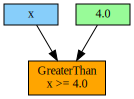

In [4]:
make_stl_graph(GThan)

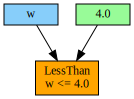

In [5]:
make_stl_graph(LThan)

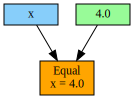

In [6]:
make_stl_graph(Eq)

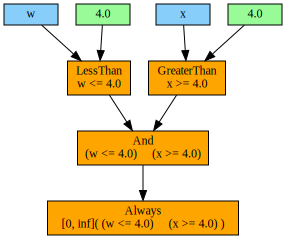

In [7]:
make_stl_graph(Alw)

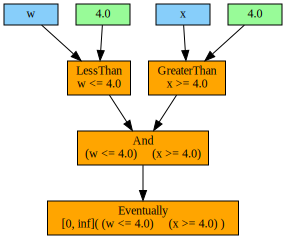

In [8]:
make_stl_graph(Ev)

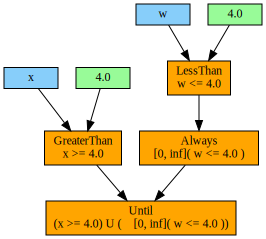

In [9]:
make_stl_graph(Unt)

## Saving a graph

In [10]:
dot = make_stl_graph(Unt)
save_graph(dot, "until_graph")

# Testing grad functionality

In [11]:
device = torch.device("cpu")
learning_rate = 0.01
def print_learning_progress(var_dict, i, loss):
    vals = [i, loss]
    string = "iteration: %i -- loss: %.3f"
    for (k,v) in var_dict.items():
        string += " ---- %s:%.3f"
        vals.append(k)
        vals.append(v)
    print(string%tuple(vals))

In [12]:
x_np = np.array([5, 4, 3, 2, 1, 0, 1, 2, 3, 4], dtype=np.float32).reshape([1, 10, 1])
w_np = np.array([2, 2, 2, 3, 4, 3, 3, 3, 2, 2], dtype=np.float32).reshape([1, 10, 1])
x = torch.tensor(x_np, requires_grad=False)
w = torch.tensor(w_np, requires_grad=False)
c = torch.tensor(6.0, dtype=torch.float, requires_grad=True)
d = torch.tensor(1.0, dtype=torch.float, requires_grad=True)
W = w + torch.randn([20,10,1], requires_grad=False)


(w <= 1.0) T (w >= 6.0)


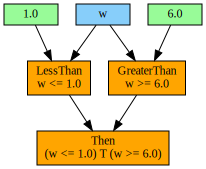

In [13]:
GThan = GreaterThan(name="w", c=c)
LThan = LessThan(name="w", c=d)

Unt = Until(subformula1=LThan, subformula2=Always(subformula=GThan))
Th = Then(subformula1=LThan, subformula2=GThan)
print(Th)
model = Th
var_dict = {"c":c, "d":d}


optimizer = torch.optim.Adam(var_dict.values(), lr=learning_rate)
scale = 5
make_stl_graph(model)

In [14]:
for i in range(500):
    learning_rate = 0.01 - 0.01*i/500. + 0.000001
    scale = 5 - i/500.
    trace1 = model.subformula1(w, scale=scale)
    trace2 = model.subformula2(w, scale=scale)
    robustness = model.robustness(trace1, trace2, scale=scale)
#     print(robustness)
    loss = torch.abs(model.robustness(trace1, trace2, scale=scale)).mean()
    print_learning_progress(var_dict, i, loss)
    loss.backward()
    with torch.no_grad():
        c -= learning_rate * c.grad
        c.grad.zero_()
        d -= learning_rate * d.grad
        d.grad.zero_()

iteration: 0 -- loss: 20.000 ---- d:1.000 ---- c:6.000
iteration: 1 -- loss: 19.742 ---- d:1.000 ---- c:5.950
iteration: 2 -- loss: 19.485 ---- d:1.000 ---- c:5.900
iteration: 3 -- loss: 19.229 ---- d:1.000 ---- c:5.850
iteration: 4 -- loss: 18.973 ---- d:1.000 ---- c:5.801
iteration: 5 -- loss: 18.718 ---- d:1.000 ---- c:5.751
iteration: 6 -- loss: 18.464 ---- d:1.000 ---- c:5.702
iteration: 7 -- loss: 18.211 ---- d:1.000 ---- c:5.652
iteration: 8 -- loss: 17.959 ---- d:1.000 ---- c:5.603
iteration: 9 -- loss: 17.707 ---- d:1.000 ---- c:5.554
iteration: 10 -- loss: 17.457 ---- d:1.000 ---- c:5.505
iteration: 11 -- loss: 17.207 ---- d:1.000 ---- c:5.457
iteration: 12 -- loss: 16.957 ---- d:1.000 ---- c:5.408
iteration: 13 -- loss: 16.709 ---- d:1.000 ---- c:5.359
iteration: 14 -- loss: 16.461 ---- d:1.000 ---- c:5.311
iteration: 15 -- loss: 16.215 ---- d:1.000 ---- c:5.262
iteration: 16 -- loss: 15.968 ---- d:1.000 ---- c:5.214
iteration: 17 -- loss: 15.723 ---- d:1.000 ---- c:5.166
it

iteration: 159 -- loss: 0.032 ---- d:1.993 ---- c:2.007
iteration: 160 -- loss: 0.043 ---- d:2.009 ---- c:1.991
iteration: 161 -- loss: 0.032 ---- d:1.993 ---- c:2.007
iteration: 162 -- loss: 0.043 ---- d:2.009 ---- c:1.991
iteration: 163 -- loss: 0.031 ---- d:1.993 ---- c:2.007
iteration: 164 -- loss: 0.042 ---- d:2.009 ---- c:1.991
iteration: 165 -- loss: 0.031 ---- d:1.993 ---- c:2.007
iteration: 166 -- loss: 0.042 ---- d:2.009 ---- c:1.991
iteration: 167 -- loss: 0.031 ---- d:1.993 ---- c:2.007
iteration: 168 -- loss: 0.042 ---- d:2.009 ---- c:1.991
iteration: 169 -- loss: 0.030 ---- d:1.993 ---- c:2.007
iteration: 170 -- loss: 0.041 ---- d:2.009 ---- c:1.991
iteration: 171 -- loss: 0.030 ---- d:1.994 ---- c:2.006
iteration: 172 -- loss: 0.041 ---- d:2.009 ---- c:1.991
iteration: 173 -- loss: 0.030 ---- d:1.994 ---- c:2.006
iteration: 174 -- loss: 0.041 ---- d:2.009 ---- c:1.991
iteration: 175 -- loss: 0.030 ---- d:1.994 ---- c:2.006
iteration: 176 -- loss: 0.041 ---- d:2.009 ---- 

iteration: 308 -- loss: 0.024 ---- d:2.005 ---- c:1.995
iteration: 309 -- loss: 0.013 ---- d:1.997 ---- c:2.003
iteration: 310 -- loss: 0.023 ---- d:2.005 ---- c:1.995
iteration: 311 -- loss: 0.013 ---- d:1.997 ---- c:2.003
iteration: 312 -- loss: 0.023 ---- d:2.005 ---- c:1.995
iteration: 313 -- loss: 0.013 ---- d:1.997 ---- c:2.003
iteration: 314 -- loss: 0.023 ---- d:2.005 ---- c:1.995
iteration: 315 -- loss: 0.013 ---- d:1.997 ---- c:2.003
iteration: 316 -- loss: 0.023 ---- d:2.005 ---- c:1.995
iteration: 317 -- loss: 0.012 ---- d:1.997 ---- c:2.003
iteration: 318 -- loss: 0.023 ---- d:2.005 ---- c:1.995
iteration: 319 -- loss: 0.012 ---- d:1.997 ---- c:2.003
iteration: 320 -- loss: 0.022 ---- d:2.005 ---- c:1.995
iteration: 321 -- loss: 0.012 ---- d:1.997 ---- c:2.003
iteration: 322 -- loss: 0.022 ---- d:2.005 ---- c:1.995
iteration: 323 -- loss: 0.012 ---- d:1.997 ---- c:2.003
iteration: 324 -- loss: 0.022 ---- d:2.005 ---- c:1.995
iteration: 325 -- loss: 0.011 ---- d:1.997 ---- 

iteration: 469 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 470 -- loss: 0.005 ---- d:2.001 ---- c:1.999
iteration: 471 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 472 -- loss: 0.005 ---- d:1.999 ---- c:2.001
iteration: 473 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 474 -- loss: 0.004 ---- d:2.001 ---- c:1.999
iteration: 475 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 476 -- loss: 0.004 ---- d:1.999 ---- c:2.001
iteration: 477 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 478 -- loss: 0.004 ---- d:2.001 ---- c:1.999
iteration: 479 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 480 -- loss: 0.003 ---- d:1.999 ---- c:2.001
iteration: 481 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 482 -- loss: 0.003 ---- d:2.001 ---- c:1.999
iteration: 483 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 484 -- loss: 0.003 ---- d:1.999 ---- c:2.001
iteration: 485 -- loss: 0.000 ---- d:2.000 ---- c:2.000
iteration: 486 -- loss: 0.002 ---- d:2.001 ---- 